/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


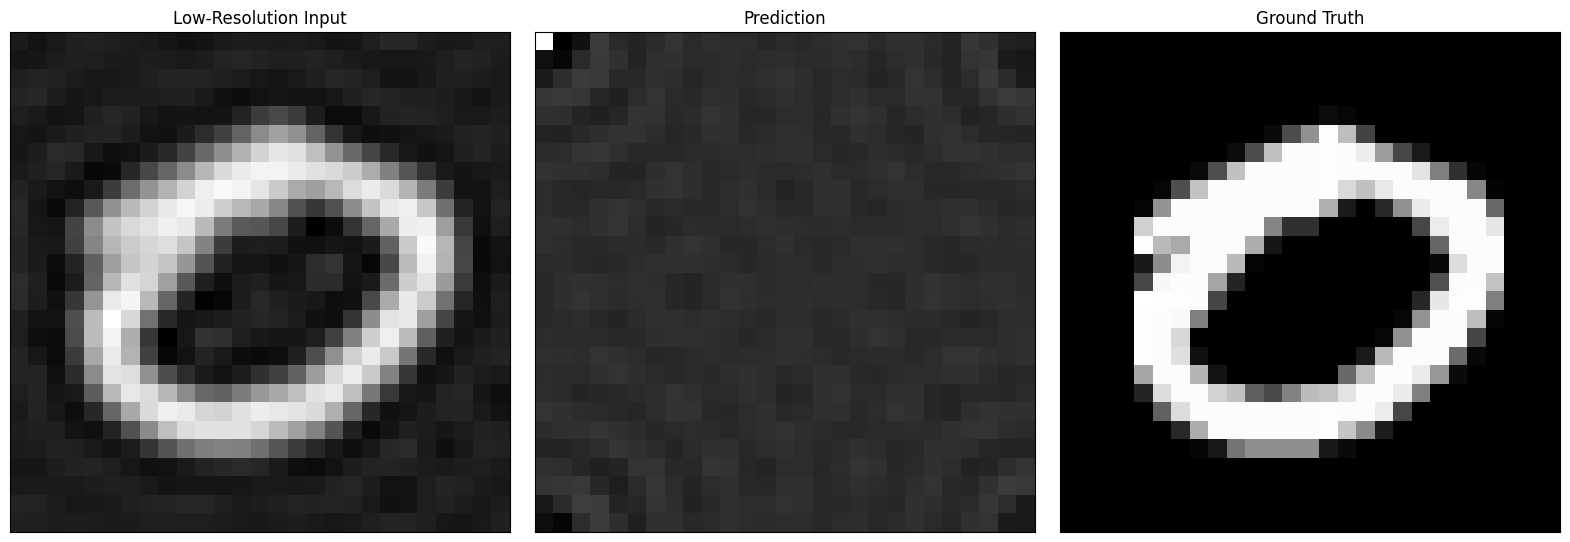

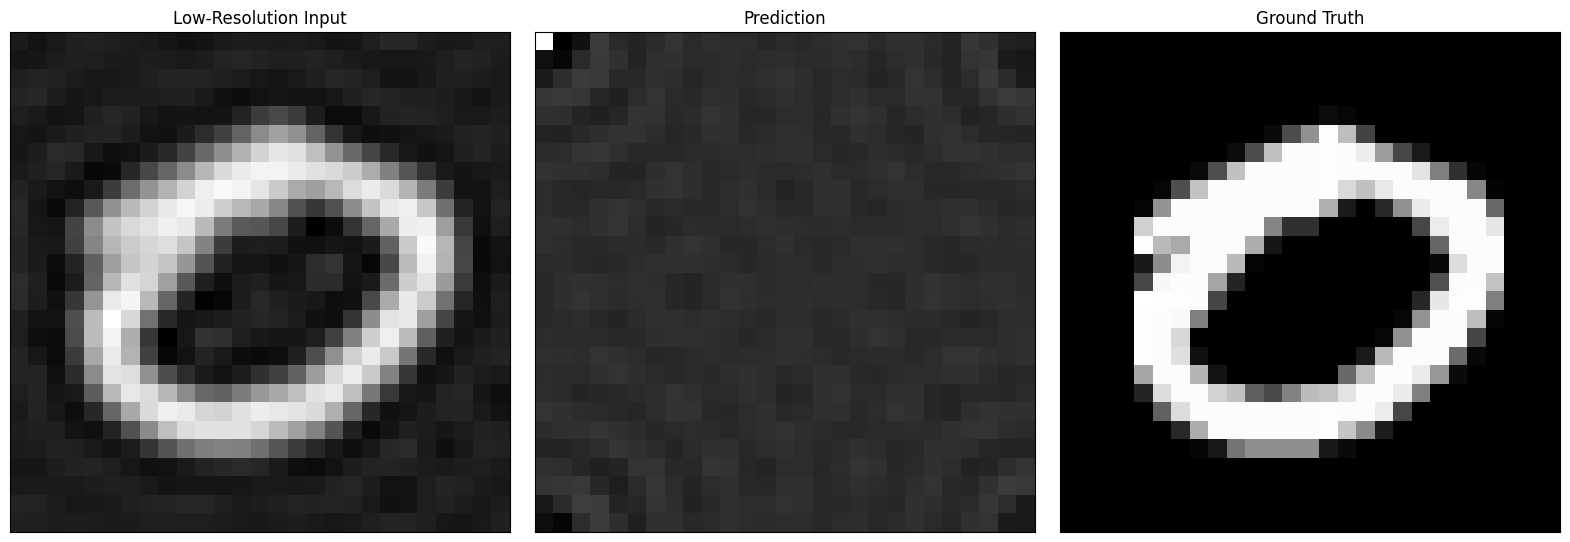

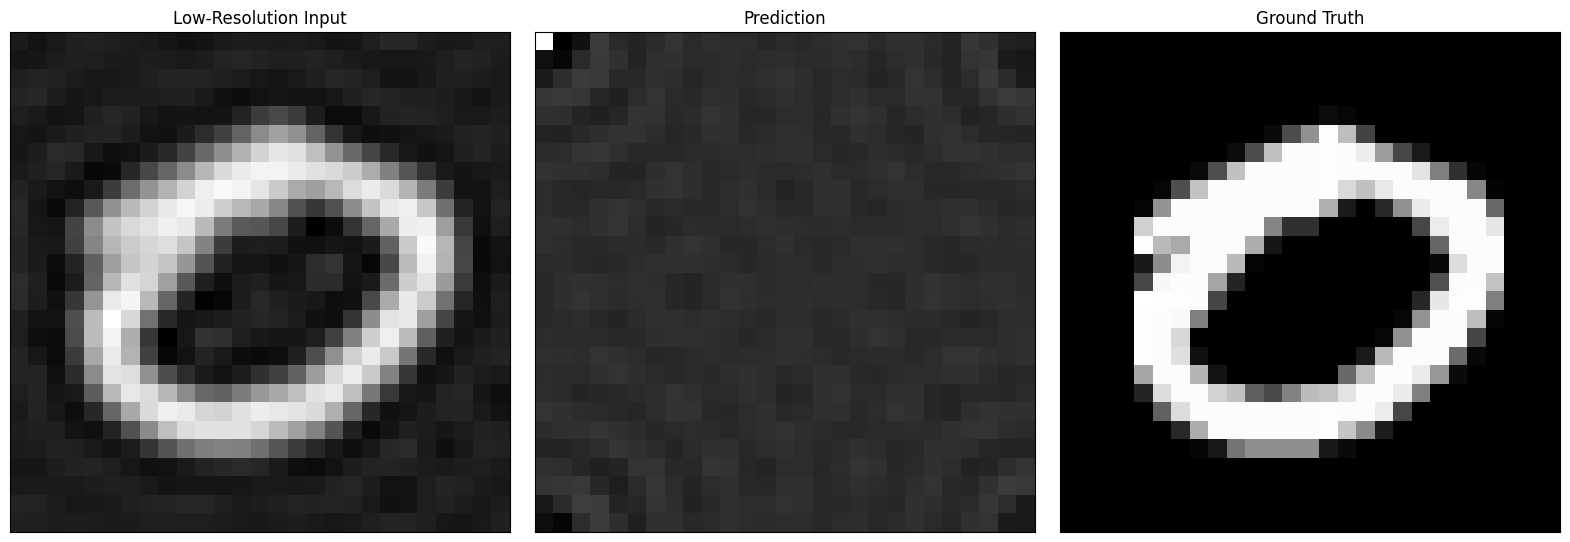

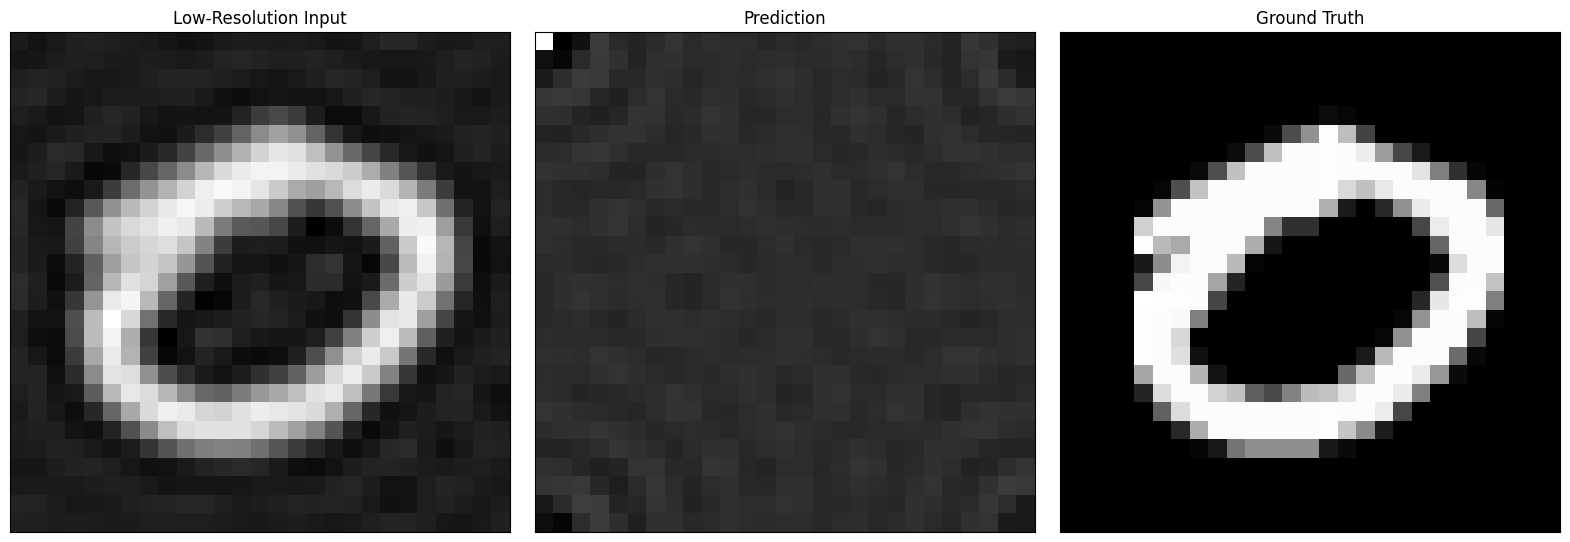

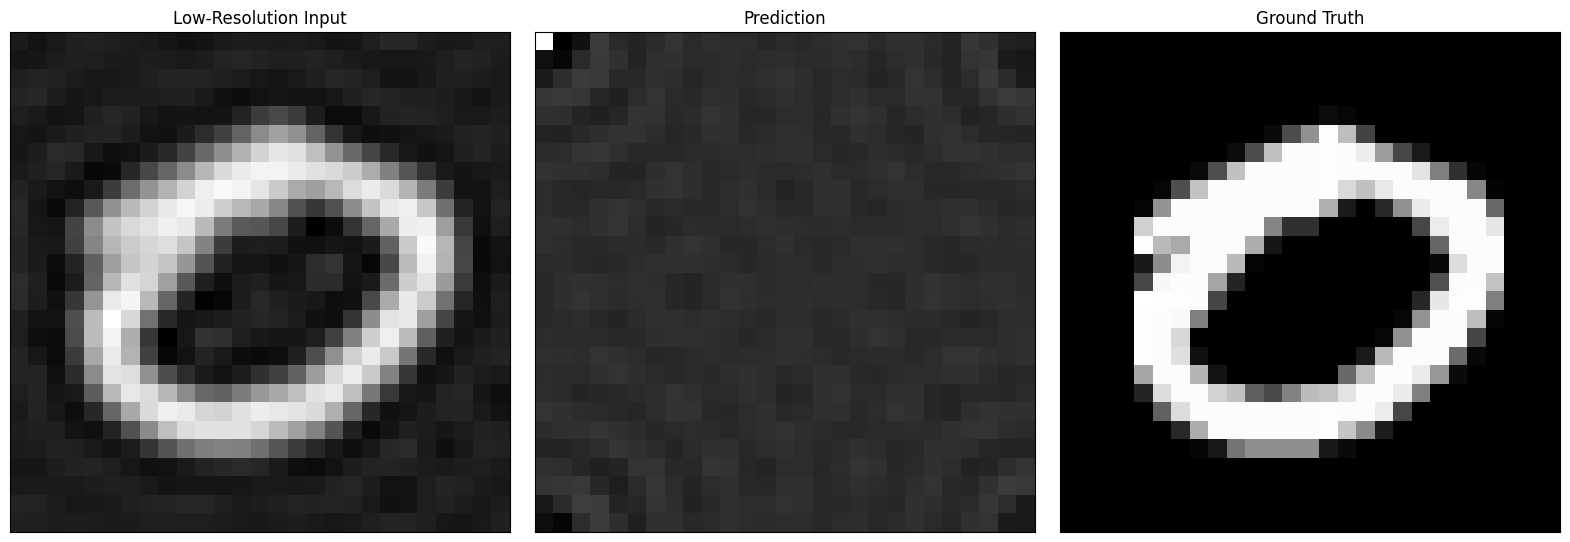

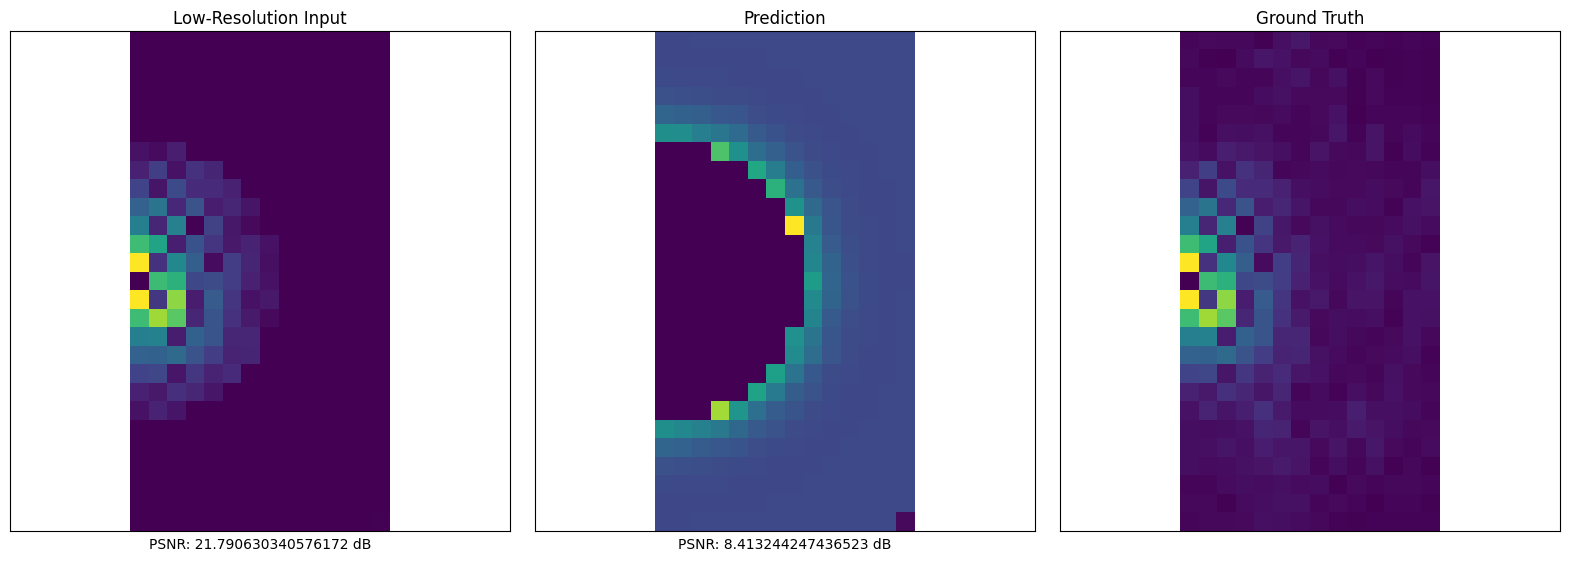

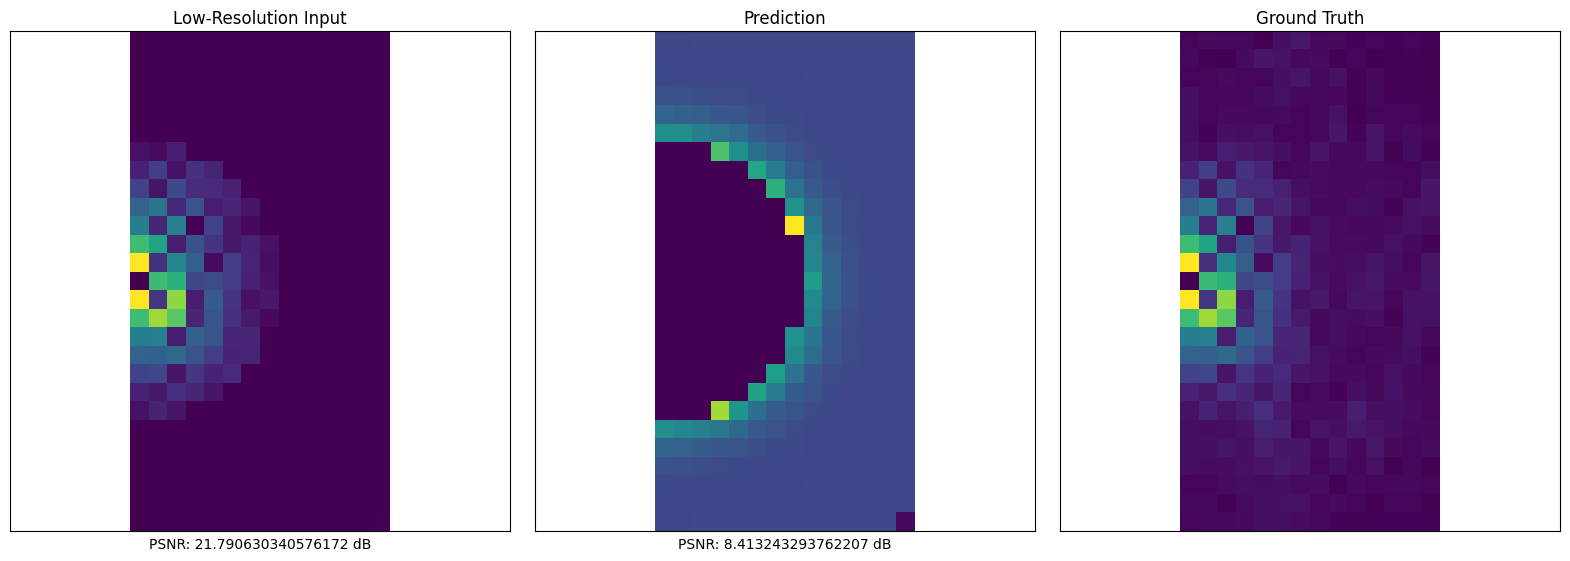

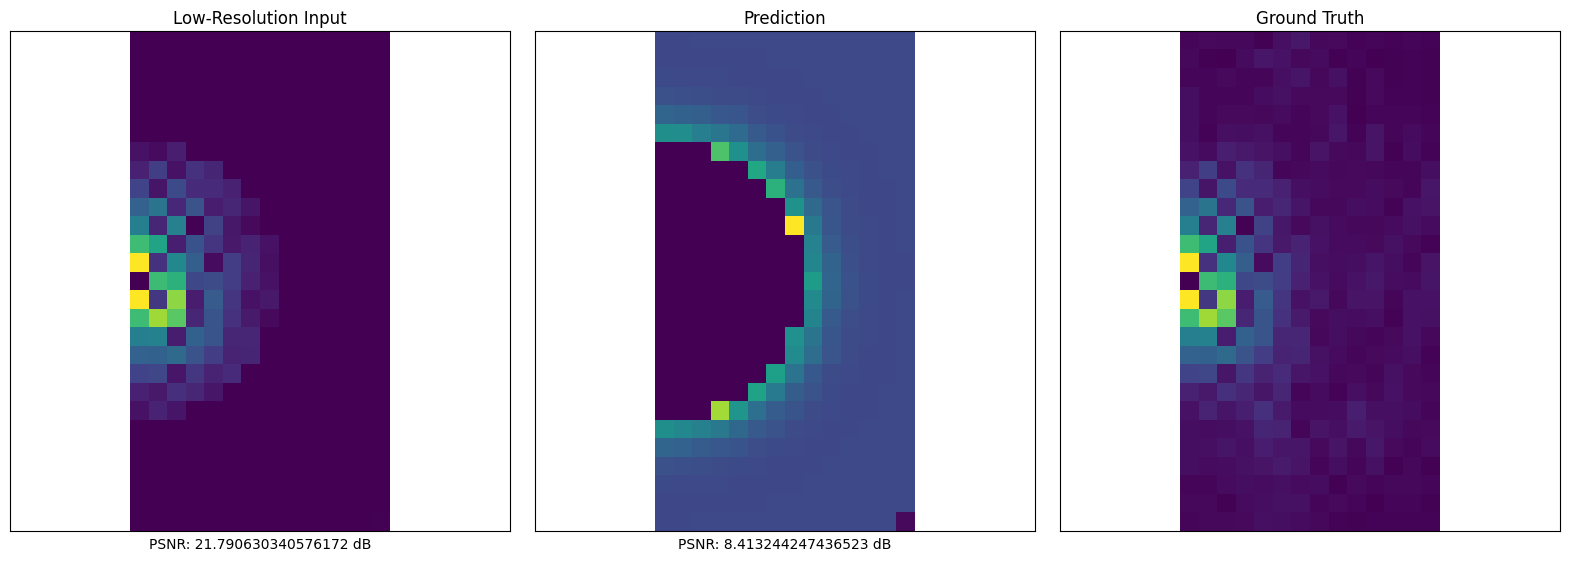

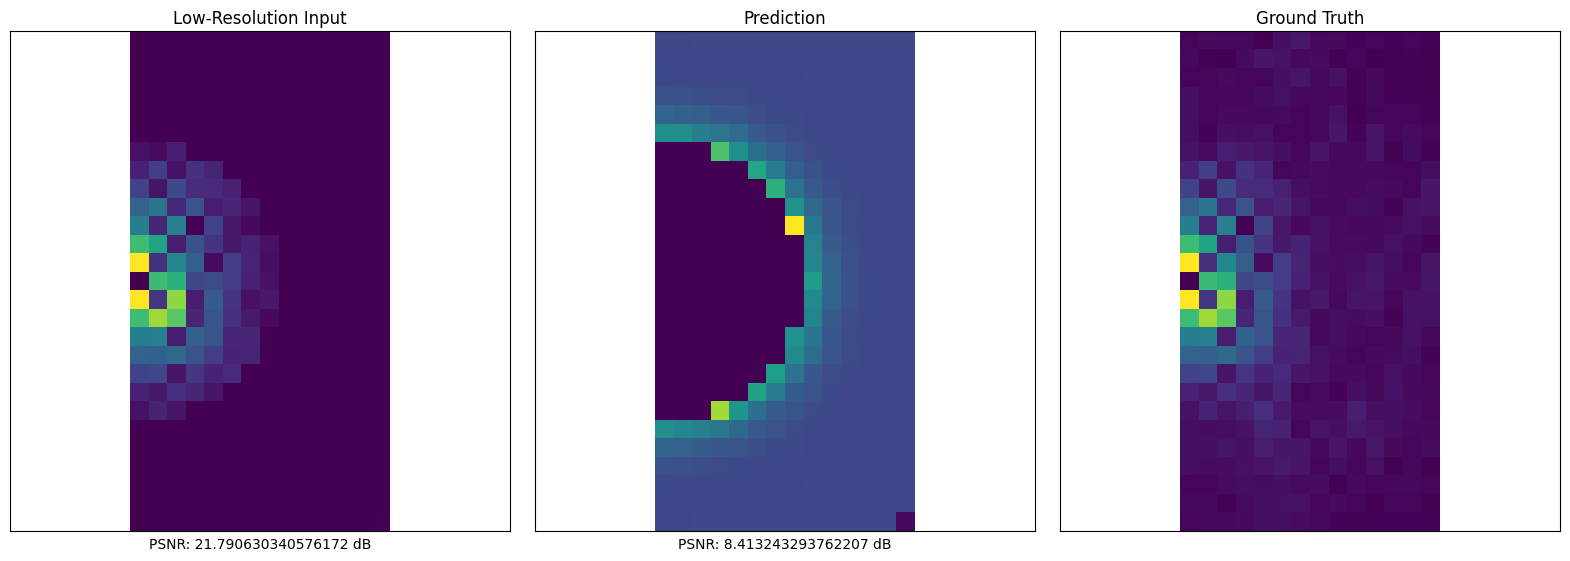

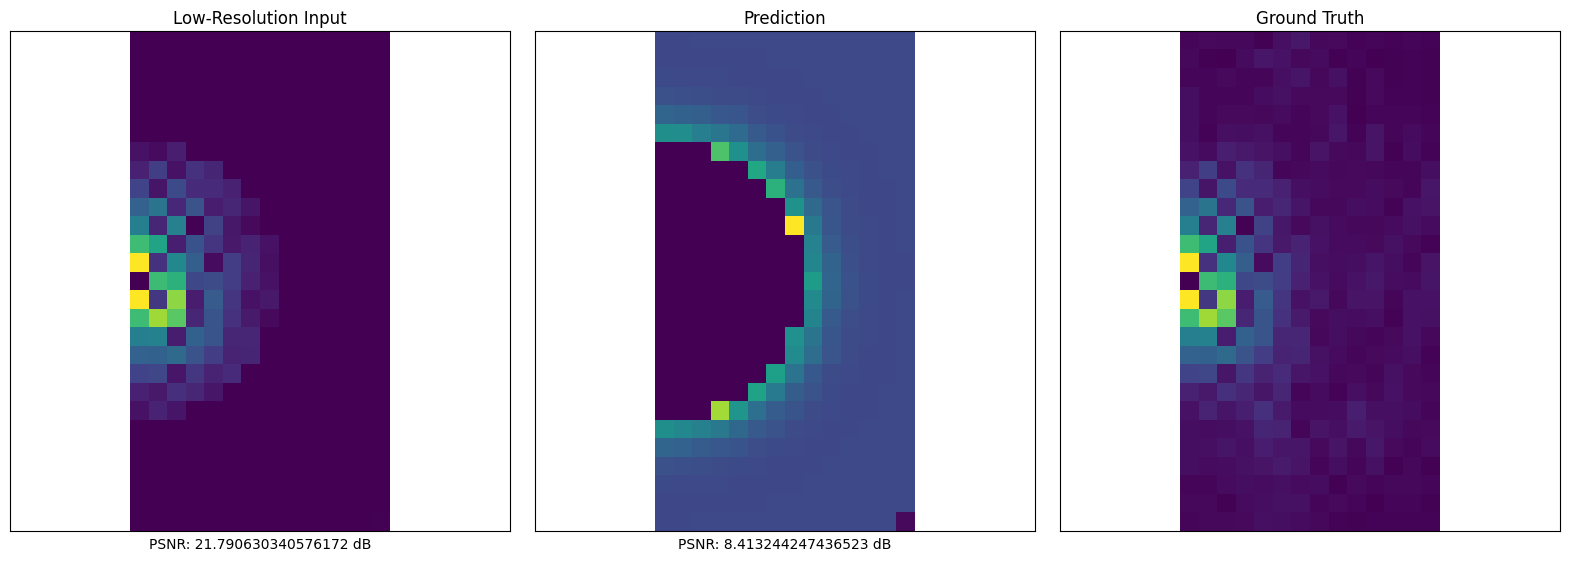

In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch

import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy
seed_everything(22122020)
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 8,model_path = '')
fig = plt.figure()
psnr_dict = {}
trained_model_path = ['/home/aman.kukde/Projects/FourierImageTransformer/models_saved/20-03_11-19-30_prod_modified_ss_True/last.ckpt']#,'/home/aman.kukde/Projects/FourierImageTransformer/models_saved/Run_07-03_15-04-41_sum_modified_overfitted_114/epoch=943-step=944.ckpt']


for model_no,path in enumerate(trained_model_path):
    model.load_test_model(path)
    model.cuda()
#     tokeniser_weights = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/model.ckpt')['state_dict']
#     for key in list(tokeniser_weights.keys()):
#         if '.encoder' in key:
#             del tokeniser_weights[key]

#     def load_partial_state_dict(model, state_dict):
#         own_state = model.state_dict()
#         for name, param in state_dict.items():
#             if name in own_state:
#                 print(f'Copying {name}')
#                 if own_state[name].size() == param.size():
#                     own_state[name].copy_(param)
#                     own_state[name].requires_grad = False
#                     own_state[name].training = False
#             # else:
#             #     print(f'Layer {name} not found in current model')
#         model.load_state_dict(tokeniser_weights, strict=False)
#         return model

#     # model = load_partial_state_dict(model, tokeniser_weights)

    trainer = Trainer(max_epochs=100, 
                    #gpus=1, # set to 0 if you want to run on CPU
                    callbacks=ModelCheckpoint(
                                                dirpath=None,
                                                save_top_k=1,
                                                verbose=False,
                                                save_last=True,
                                                monitor='Validation/avg_val_loss',
                                                mode='min'
                                            ), 
                    deterministic=True)
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
    for fc, (mag_min, mag_max) in dm.train_dataloader():
        break
    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    x_fc = fc[:, flatten_order][:, :model.input_seq_length]
    pred = model.sres.forward_i(x_fc,model.input_seq_length)
    # pred[:,96:] = (pred[:,96:] - pred[:,96:].min()) / (pred[:,96:].max() - pred[:,96:].min())
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)

                        
    lowres = torch.zeros_like(pred)
    # lowres += fc.min()
    lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)
    

    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)

    psnr_dict[str(model_no)] = pred_psnr.cpu().detach() - lowres_psnr.cpu().detach()

    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True, label = "model_no = "+str(model_no))
    fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(5):
        fig2 = plt.figure(figsize=(31/2., 10/2.)) 
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');

    from sklearn.random_projection import sample_without_replacement


    diff = []
    for i in range(5):
        sample = i
        # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
        # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
        pred_psnr = PSNR(gt_img, pred_img)
        # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
        ax2.set_title('Ground Truth');
        # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
        ax2.axis('equal');
        diff.append(lowres_psnr - pred_psnr)
        

In [2]:
np.set_printoptions(suppress = True)
(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0) - np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0) ).round(4) *100

array([[  -802.14   ,   -804.23004,   -806.19   ,   -806.68   ,
          -810.4    ,   -811.76996,   -812.09   ,   -813.1    ,
          -814.23   ,   -814.92993,   -815.79   ,   -816.07   ,
          -816.71   ,   -816.98   ],
       [  -800.94995,   -801.14   ,   -799.86   ,   -799.04   ,
          -799.77997,   -802.22   ,   -807.45   ,   -811.55994,
          -812.27997,   -813.86993,   -814.47003,   -815.13995,
          -815.97003,   -816.82996],
       [  -820.79   ,   -818.78   ,   -814.27   ,   -805.94995,
          -803.81   ,   -801.04   ,   -799.34   ,   -805.2    ,
          -811.24   ,   -812.07   ,   -813.61   ,   -814.41003,
          -815.03   ,   -816.27997],
       [  -911.62006,   -902.22   ,   -888.74   ,   -849.96   ,
          -836.49   ,   -815.12006,   -804.68   ,   -799.68   ,
          -801.14   ,   -809.37006,   -811.99   ,   -813.45996,
          -814.47003,   -815.57996],
       [ -1201.11   ,  -1140.76   ,  -1114.91   ,  -1006.98004,
          -979.14   

In [3]:
np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0).shape

(27, 14)

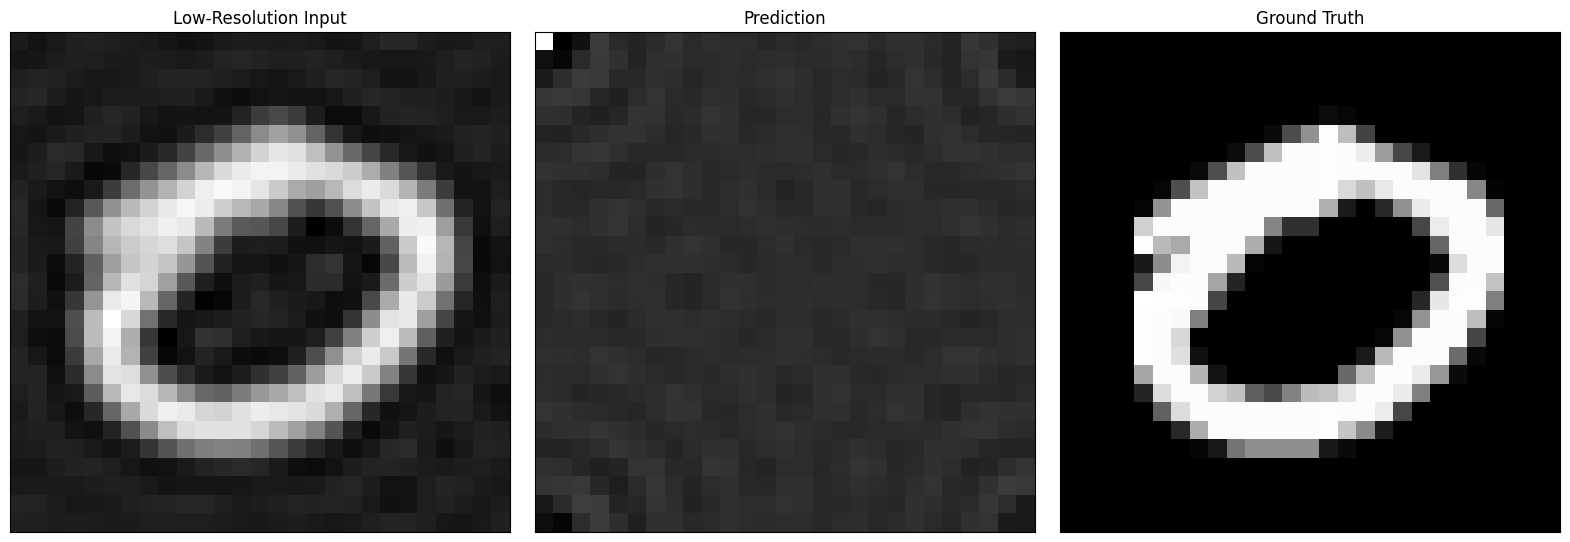

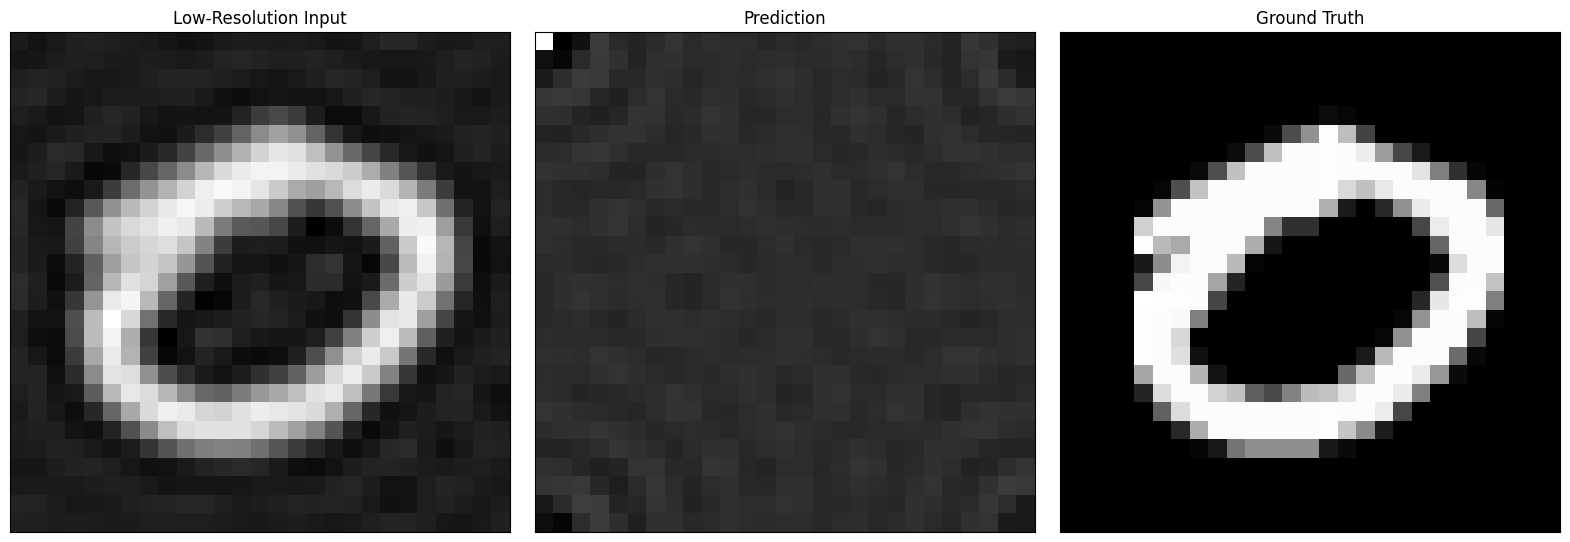

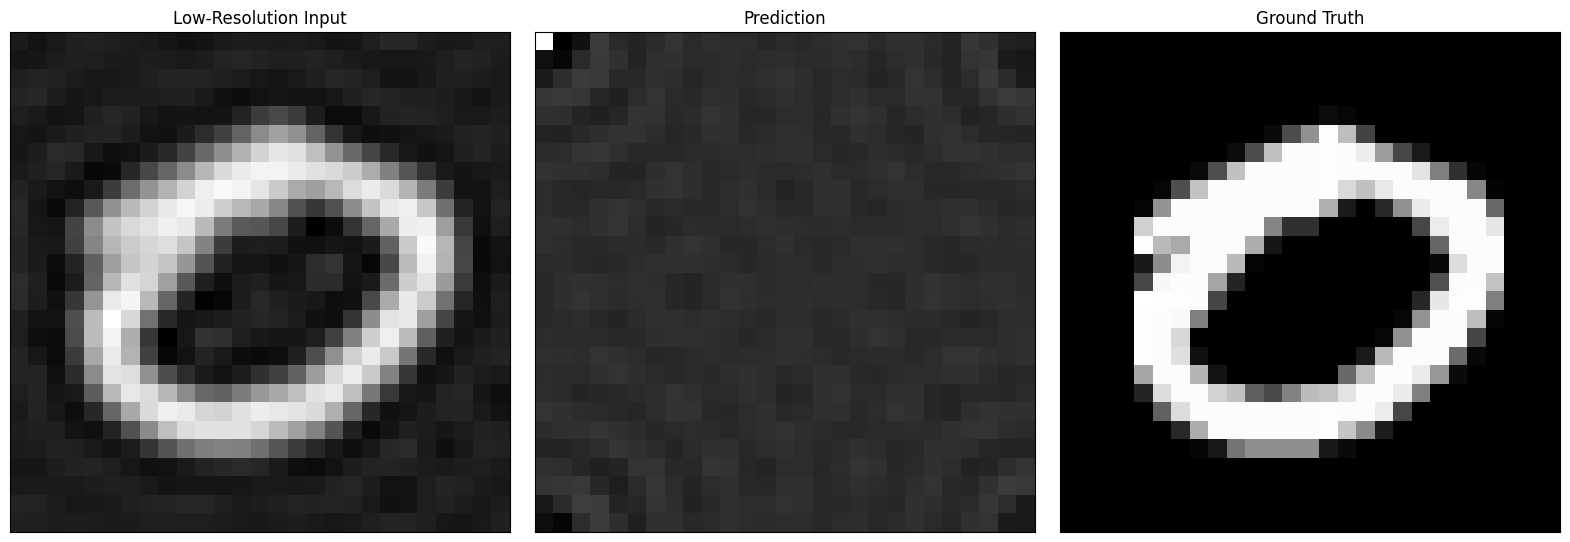

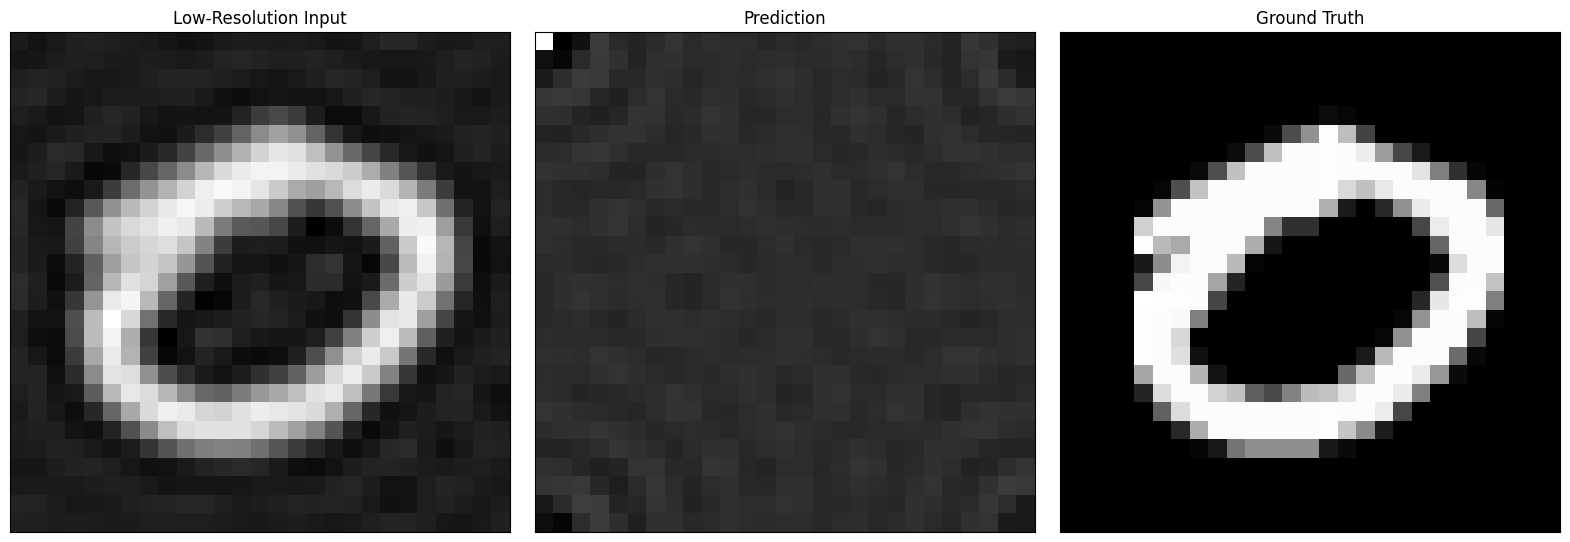

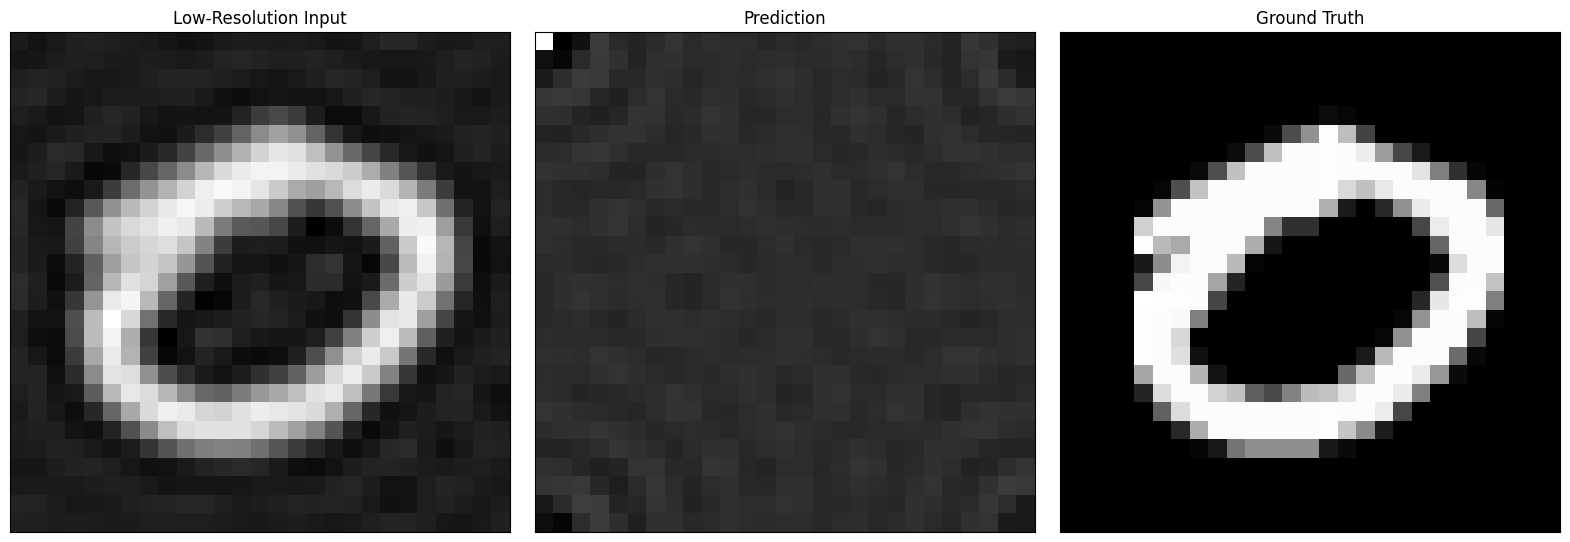

In [4]:
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(5):
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

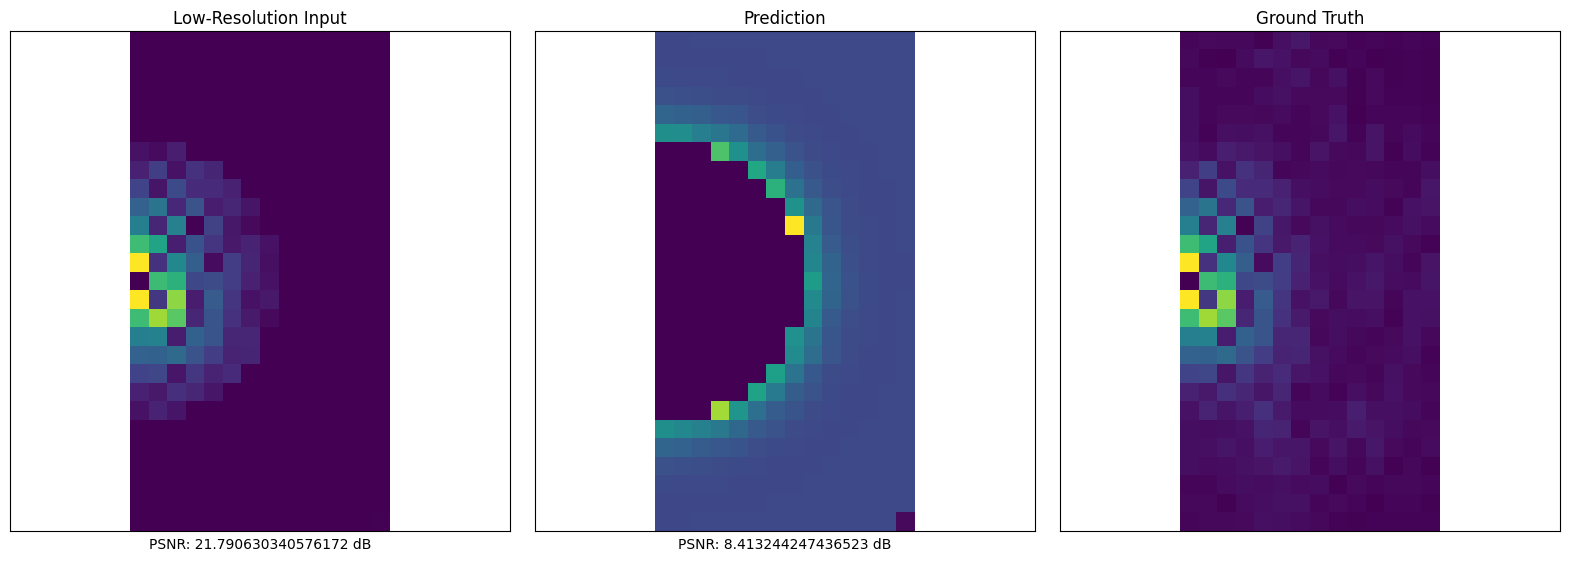

In [5]:
from sklearn.random_projection import sample_without_replacement


diff =[]
for i in range(1):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)

<Axes: >

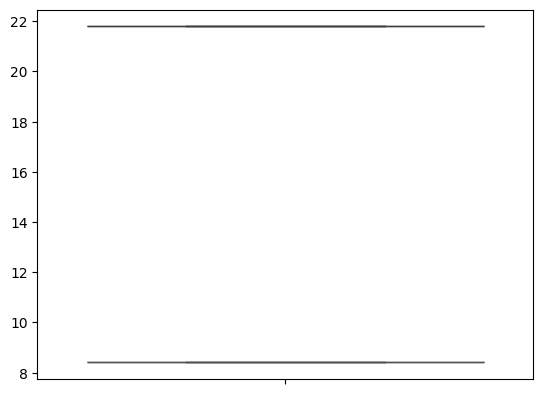

In [6]:
sns.boxplot(lowres_psnr.cpu().detach().numpy())
sns.boxplot(pred_psnr.cpu().detach().numpy())